In [14]:
import torch
from ESRGAN import *
import torch

import numpy as np
from PIL import Image
import torchvision
torchvision.disable_beta_transforms_warning()
import FILM


from natsort import natsorted
import glob 
import cv2
from datetime import datetime,timedelta
import matplotlib.pyplot as plt 
import os 
from astropy.io import fits
from scipy.ndimage import shift, median_filter
from astropy.wcs import WCS

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from skimage import exposure
import RIFE
%matplotlib widget
import unet2

In [2]:
def difference(img,img_prev,header,header_prev,ratio1,ratio2,center):

    wcs = WCS(header,key='A')
    center_prev = wcs.all_world2pix(header_prev["crval1a"],header_prev["crval2a"], 0)
    shift_arr = np.array([center_prev[1]-center[1],center_prev[0]-center[0]])*ratio1/ratio2
    difference   = np.float32(img-shift(img_prev,shift_arr, mode='nearest',prefilter=False)) 

    return difference # cv2.medianBlur(difference ,5)



def insert_cut(dates,dtime,diff,cuts,mid,pix):
    for i,d in enumerate(dates):
        if(np.abs((d-dtime).total_seconds()/60)<20.0):
            img_rescale_hs = diff[mid-pix:mid+pix,:].T
            cuts[:,i,:]= img_rescale_hs
            break
    return cuts

In [3]:
events_selected = [ 
                    # "03/09/2009",
                    # "03/04/2010",
                    # "08/04/2010",
                    # "23/05/2010",
                    # "16/06/2010",
                    # "01/08/2010",
                    # "15/12/2010",
                    # "30/01/2011",
                    # "14/02/2011",
                    # "23/06/2011",
                    # "02/08/2011",
                    # "06/09/2011",
                    # "22/10/2011",
                    # "12/07/2012",
                    # "15/01/2013",
                    # "30/09/2013",
                    # "15/04/2020",
                    # "23/06/2020",
                    # "09/07/2020",
                    # "20/07/2020",
                    # "30/09/2020",
                    # "26/10/2020",
                    # "07/12/2020",
                    # "11/02/2021",
                    # "20/02/2021",
                    # "10/04/2021",
                    # "22/04/2021",
                    # "09/05/2021",
                    # "29/05/2021",
                    # "23/08/2021",
                    # "13/09/2021",
                    # "09/10/2021",
                    "04/04/2022",
                    #"11/04/2022",
                    #"27/06/2022",
                    #"03/07/2022",
                    #"03/11/2022",
                    #"31/12/2022",
                    #"16/04/2023",
                    #"21/04/2023"
                ]

new_events_list = []
for i in range(0,len(events_selected)):
    date = datetime.strptime(events_selected[i],'%d/%m/%Y')
    dates = [
             datetime.strptime(events_selected[i],'%d/%m/%Y')-timedelta(days=3),
             datetime.strptime(events_selected[i],'%d/%m/%Y')-timedelta(days=2),
             datetime.strptime(events_selected[i],'%d/%m/%Y')-timedelta(days=1),
             datetime.strptime(events_selected[i],'%d/%m/%Y'),
             datetime.strptime(events_selected[i],'%d/%m/%Y')+timedelta(days=1),
             datetime.strptime(events_selected[i],'%d/%m/%Y')+timedelta(days=2),
             datetime.strptime(events_selected[i],'%d/%m/%Y')+timedelta(days=3)
             ]
    new_events_list.append(dates)


In [4]:
model = unet2.ResUnet(2,full_size=512)
model.load_state_dict(torch.load("gan_gen_ssim3.pth", map_location=torch.device('cpu')))
model.to(device).eval()



In [6]:
def adaptive_contrast_stretching(jplot):

    sizey = jplot.shape[0]
    window_size = sizey//20
    stride = int(window_size*0.66)

    final_plots = []
    
    for i in range(0,sizey-window_size+stride,stride):
        idx1 = i
        idx2 = i+window_size
        tempplot = np.zeros(jplot.shape)

        p2, p96 = np.nanpercentile(jplot[idx1:idx2,:].copy(), (5, 98))
        tempplot[idx1:idx2,:] = exposure.rescale_intensity(jplot[idx1:idx2,:], in_range=(p2, p96))
        final_plots.append(tempplot )
    
    final_plots = np.asarray(final_plots).max(0)

    return final_plots

THIS WILL RUN ON DEVICE: cuda:1
IN CHANNELS    128
END of day 2022-04-07 01:18:10


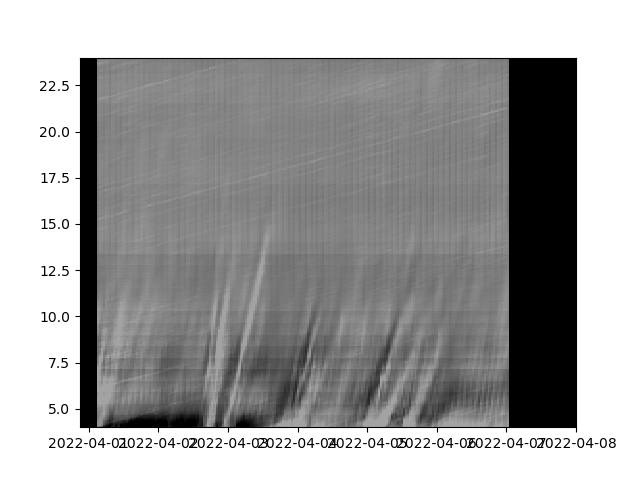

IndexError: list index out of range

In [13]:
device = torch.device("cpu")
if(torch.backends.mps.is_available()):
    device = torch.device("mps")
elif(torch.cuda.is_available()):
    device = torch.device("cuda:1")


print("THIS WILL RUN ON DEVICE:", device)

# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm


model = FILM.Interpolator()
model.load_state_dict(torch.load("FILM_saved.pth",map_location=torch.device('cpu')))
model.to(device).eval()

#model = RIFE.Model()
#model.load_model("RIFE_test.pth")
#model.device()



dt1 = torch.ones((1)).to(device) * 0.25
dt2 = torch.ones((1)).to(device) * 0.75
cadence = 40
slice_shape = 20


imgs_paths = natsorted(glob.glob("../res_model_final4/*"))
index_event = 0
jplots = []

date1 = new_events_list[index_event][0]  - timedelta(hours=3)
date2 = new_events_list[index_event][-1] + timedelta(hours=24)
dates = []
current_date = date1
while current_date <= date2:
    dates.append(current_date)
    current_date = current_date + timedelta(minutes=cadence)
dates.append(date2)

cuts = np.zeros((512,len(dates),slice_shape))



with torch.no_grad():
    for p in range(1,len(imgs_paths)-1):

        time1 = datetime.strptime(imgs_paths[p-1].split("/")[-1][:-8], '%Y-%m-%dT%H-%M-%S')
        time2 = datetime.strptime(imgs_paths[p].split("/")[-1][:-8], '%Y-%m-%dT%H-%M-%S')
        diff_time = (time2-time1).total_seconds()

        if(diff_time/3600<3 and time1 > new_events_list[index_event][0]):

            S1 = torch.tensor(np.asarray(Image.open(imgs_paths[p-1]).convert("L"))/255.0).float().unsqueeze(0).unsqueeze(1).to(device)
            S2 = torch.tensor(np.asarray(Image.open(imgs_paths[p]).convert("L"))/255.0).float().unsqueeze(0).unsqueeze(1).to(device)

            output1 = model(S1,S2,dt1.unsqueeze(1))[0,0,:,:].cpu().numpy()
            output2 = model(S1,S2,dt2.unsqueeze(1))[0,0,:,:].cpu().numpy()
            
            #output1 = model.inference(S1,S2,timestep=0.33)
            #output1 = output1[0,0,:,:].cpu().numpy()
            #output2 = model.inference(S1,S2,timestep=0.66)
            #output2= output2[0,0,:,:].cpu().numpy()

            S1 = S1[0,0,:,:].cpu().numpy()
            S2 = S2[0,0,:,:].cpu().numpy()

            timeout1 = time1+timedelta(minutes=40)
            timeout2 = time1+timedelta(minutes=80)
            
            #fig, ax = plt.subplots(1,4)
            #ax[0].imshow(S1,cmap='twilight')
            #ax[1].imshow(output1,cmap='twilight')
            #ax[2].imshow(output2,cmap='twilight')
            #ax[3].imshow(S2,cmap='twilight')
            #plt.show()
            


            name = '../test_fits/'+imgs_paths[p-1].split("/")[-1][:-3]+"fts"
            filea = fits.open(name)
            hdr = filea[0].header
            filea.close()

            name = '../test_fits/'+imgs_paths[p].split("/")[-1][:-3]+"fts"
            filea = fits.open(name)
            hdr2= filea[0].header
            filea.close()


            diff1 = difference(output1,S1,hdr2,hdr,2,3,(126.5,126.5))
            diff2 = difference(output2,output1,hdr2,hdr,2,3,(126.5,126.5))
            diff3 = difference(S2,output2,hdr2,hdr,2,3,(126.5,126.5))



            cuts = insert_cut(dates,timeout1,output1,cuts,256,slice_shape//2)
            cuts = insert_cut(dates,timeout2,output2,cuts,256,slice_shape//2)
            cuts = insert_cut(dates,time2,S2,cuts,256,slice_shape//2)

            #diff = difference(S2,S1,hdr2,hdr,2,1,(126.5,126.5))
            cuts = insert_cut(dates,time1,S1,cuts,256,slice_shape//2)
            #cuts = insert_cut(dates,time2,S2,cuts,256,slice_shape//2)


            # fig,ax = plt.subplots(1,3)
            # ax[0].imshow(diff1)
            # ax[1].imshow(diff2)
            # ax[2].imshow(diff3)
            # plt.savefig("testdiffs.png")

        if(time2>new_events_list[index_event][-1]):
            print("END of day",time2)
            a,b,c = cuts.shape
            cuts =  cuts.reshape((a,b*c))
            cuts = adaptive_contrast_stretching(cuts)
            cuts = cuts.reshape((a,b,c))
            cuts = np.median(cuts,2)
            
            p2, p96 = np.nanpercentile(cuts.copy(), (0, 99))
            cuts = exposure.rescale_intensity(cuts, in_range=(p2, p96))
            

            vmin_h1 = np.nanmedian(cuts) - 2 * np.nanstd(cuts)
            vmax_h1 = np.nanmedian(cuts) + 2 * np.nanstd(cuts)


            # cuts = (cuts - vmin_h1)/(vmax_h1-vmin_h1)
            # cuts = (cuts - cuts.min())/(cuts.max()-cuts.min())

            # img = Image.fromarray((cuts*255).astype(np.uint8))
            # img.save("results_plots/res_jplot"+new_events_list[index_event][3].strftime("%Y-%m-%d").replace(":","-")+".png")

            fig,ax = plt.subplots(1,1)
            ax.imshow(cuts,
                       aspect="auto",
                       origin='lower',
                       interpolation='none',
                       extent = [dates[0],dates[-1],4,24],
                       cmap='gray',
                       vmin=vmin_h1,
                       vmax=vmax_h1
                     )
            #ax.set_xlim([dates[30],dates[150]])

            #plt.savefig("results_plots/res_jplot"+new_events_list[index_event][3].strftime("%Y-%m-%d").replace(":","-")+".png")
            plt.show()
            index_event+=1
            date1 = new_events_list[index_event][0]
            date2 = new_events_list[index_event][-1] + timedelta(hours=24)
            dates = []
            current_date = date1
            while current_date <= date2:
                dates.append(current_date)
                current_date = current_date + timedelta(minutes=cadence)
            dates.append(date2)
            cuts = np.zeros((512,len(dates),slice_shape))